# Surface Mapping Using AprilTags and ArUco markers

## Introduction to Fiducial Markers

Fiducial markers (for a review see[<sup>1</sup>](https://doi.org/10.1007/s10846-020-01307-9)) are specially designed visual markers used to establish spatial correspondence between different coordinate systems. They serve as reference points in images that can be reliably and accurately detected, allowing us to map between video/image coordinates and real-world coordinates. In eye-tracking applications, fiducial markers enable us to transform gaze coordinates from the camera's perspective to the coordinates of the observed surface (e.g., a computer screen).

For surface mapping, PyNeon supports the use of two widely adopted fiducial marker systems: AprilTags and ArUco markers. Both have a barcode-like appearance and encode unique IDs in their patterns.

- [AprilTag](https://april.eecs.umich.edu/software/apriltag): see references<sup>[2](https://doi.org/10.1109/ICRA.2011.5979561),[3](https://doi.org/10.1109/IROS.2016.7759617)</sup>. Pupil Labs offers AprilTag-based surface mapping in [Neon Player](https://docs.pupil-labs.com/neon/neon-player/surface-tracker/) and in [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/enrichments/marker-mapper/). However, PyNeon's implementation allows for more customizable detection parameters.

- [ArUco](https://www.uco.es/investiga/grupos/ava/portfolio/aruco/): see reference<sup>[4](https://doi.org/10.1016/j.patcog.2014.01.005)</sup>. Pre-defined ArUco dictionaries for generating and detecting these makers are integrated into OpenCV. Therefore, PyNeon uses OpenCV's ArUco module ([cv2.aruco](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html)) for marker detection (including AprilTag).

<p><a href="https://commons.wikimedia.org/wiki/File:Comparison_of_augmented_reality_fiducial_markers.svg#/media/File:Comparison_of_augmented_reality_fiducial_markers.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Comparison_of_augmented_reality_fiducial_markers.svg" alt="Comparison of augmented reality fiducial markers.svg" width="600"/></a>

## Reading Sample Data

To illustrate surface mapping using fiducial markers, we will use a sample dataset called "markers". the dataset includes two recordings: one with AprilTag markers and another with ArUco markers. In both recordings, a pilot participant viewed a set of artworks displayed on a computer screen. Our goal is the map the gaze and fixation data onto the computer screen using the fiducial markers present in the scene camera video.

In [1]:
from pyneon import Dataset, get_sample_data
import matplotlib.pyplot as plt

# Load a sample recording
dataset_dir = get_sample_data("markers", format="cloud")
dataset = Dataset(dataset_dir)

Let's start with the AprilTag recording.

In [2]:
rec = dataset.recordings[0]
print(rec)


Data format: cloud
Recording ID: 16841adb-da58-4c42-be02-f052c3c43db3
Wearer ID: 028e4c69-f333-4751-af8c-84a09af079f5
Wearer name: Pilot
Recording start time: 2025-09-22 00:25:14.096000
Recording duration: 244820000000 ns (244.82 s)



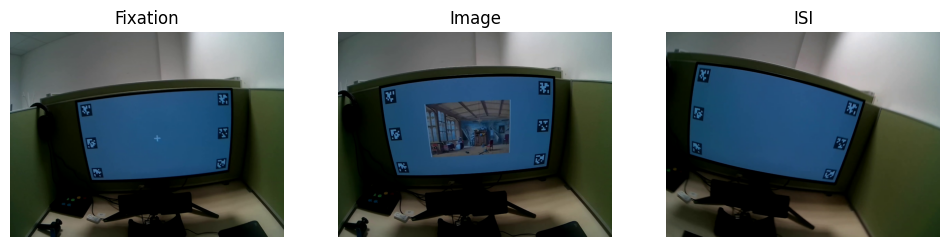

In [3]:
video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(380, ax=axs[0], show=False)
video.plot_frame(500, ax=axs[1], show=False)
video.plot_frame(520, ax=axs[2], show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 5 frames.

In [4]:
from pathlib import Path
from pyneon import Stream
if Path("detected_markers.csv").exists():
    detected_markers = Stream("detected_markers.csv")
else:
    detected_markers = video.detect_markers("36h11")

In [5]:
detected_markers.data.to_csv("detected_markers.csv")

ValueError: Detections must contain marker corner columns or a 'corners' column.

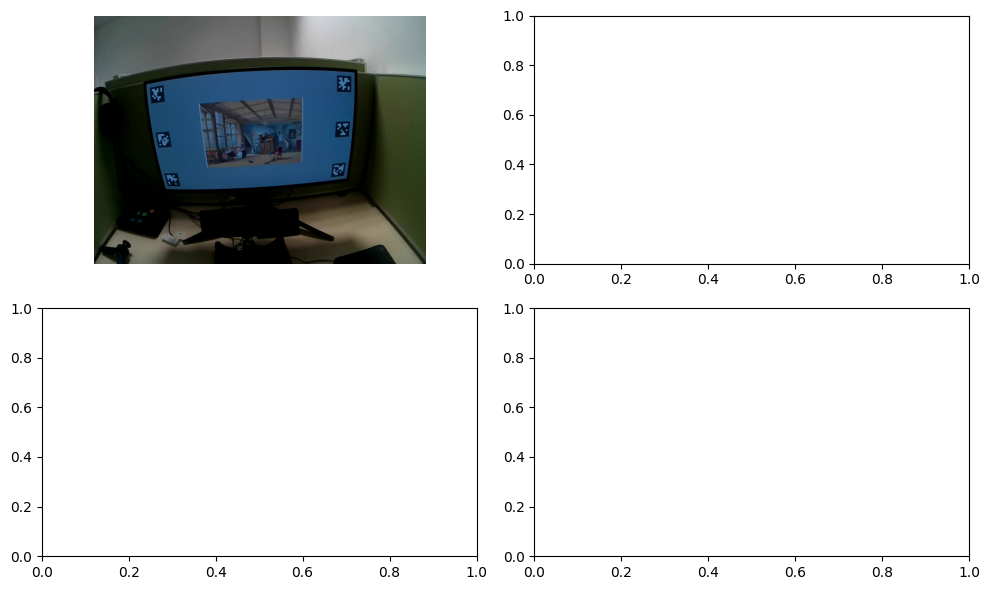

In [6]:
# Plot a few frames with detected markers
fig, axs = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
axs = axs.flatten()
video.plot_detections(detected_markers, frame_index=500, ax=axs[0], show=False)
video.plot_detections(detected_markers, frame_index=1000, ax=axs[1], show=False)
video.plot_detections(detected_markers, frame_index=1500, ax=axs[2], show=False)
video.plot_detections(detected_markers, frame_index=2000, ax=axs[3], show=False)
plt.show()

Having detected the markers (apriltags), we now need to provide information on the real-world coordinates of our markers. This is solved via a marker_info dataframe, which we generate below.

The marker_info contains information about where the markers are located in real-world coordinates (in this case, the computer screen coordinates in pixels). Each marker is identified by its unique ID, and we specify the coordinates of its center as well as its size.

The computer we used for this experiment has a screen resolution of 2560 x 1440 pixels. The markers were placed at the corners of the screen (with a 50 pixel margin), each with a size of 200x200 pixels. The coordinates in the marker_info dataframe reflect these placements.

  marker name  size  center x  center y
0     36h11_0   200       150     150.0
1     36h11_1   200      2410     150.0
2     36h11_2   200      2410     720.0
3     36h11_3   200      2410    1290.0
4     36h11_4   200       150    1290.0
5     36h11_5   200       150     720.0


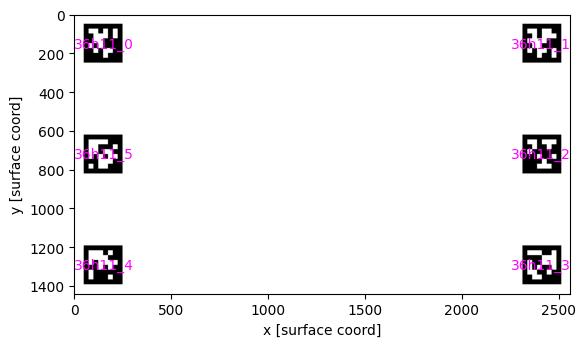

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='x [surface coord]', ylabel='y [surface coord]'>)

In [ ]:
from pyneon.vis import plot_marker_layout
import pandas as pd

width = 2560
height = 1440
marker_layout = pd.DataFrame(
    {
        "marker name": [f"36h11_{i}" for i in range(6)],
        "size": 200,
        "center x": [150, width - 150, width - 150, width - 150, 150, 150],
        "center y": [150, 150, height/2, height - 150, height - 150, height/2],
    }
)
print(marker_layout)
plot_marker_layout(marker_layout, surface_size=(width, height))

With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [ ]:
from pyneon.video import find_homographies

homographies = find_homographies(
    detected_markers,
    marker_layout,
)

Computing homographies: 100%|██████████| 6992/6992 [00:18<00:00, 374.23it/s]


In [ ]:
print(homographies.data.head())

                     homography (0,0)  homography (0,1)  homography (0,2)  \
timestamp [ns]                                                              
1758493517556588888          4.353780         -0.550944      -4053.765073   
1758493517589911111          5.301771         -0.667602      -4963.924687   
1758493517623233333          4.732940         -0.542657      -4450.053021   
1758493517656555555          5.429459         -0.612509      -5092.626504   
1758493517689877777          5.314940         -0.583451      -4959.439257   

                     homography (1,0)  homography (1,1)  homography (1,2)  \
timestamp [ns]                                                              
1758493517556588888          0.583868          3.769592      -1214.706373   
1758493517589911111          0.652812          4.574443      -1456.144463   
1758493517623233333          0.508835          4.079739      -1202.814462   
1758493517656555555          0.672325          4.775235      -1510.127187  

In [ ]:
gaze_on_surface = rec.gaze.apply_homographies(homographies)
fixations_on_surface = rec.fixations.apply_homographies(homographies)

C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:66: UserWarning: 297 out of 48219 requested timestamps are outside the data time range and will have empty data.
  warn(
C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:103: UserWarning: 227 out of 48219 requested timestamps exceed max_gap_ms=500 relative to neighboring samples and will have empty data.
  warn(
Applying homographies to gaze points: 100%|██████████| 47695/47695 [00:38<00:00, 1242.52it/s]
C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:66: UserWarning: 4 out of 476 requested timestamps are outside the data time range and will have empty data.
  warn(
C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:103: UserWarning: 2 out of 476 requested timestamps exceed max_gap_ms=500 relative to neighboring samples and will have empty data.
  warn(


with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

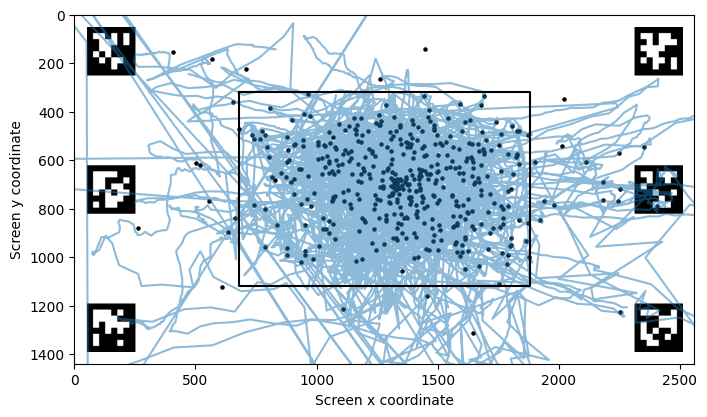

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_marker_layout(marker_layout, ax=ax, show_marker_names=False, show=False)
ax.plot(
    gaze_on_surface.data["gaze x [surface coord]"],
    gaze_on_surface.data["gaze y [surface coord]"],
    alpha=0.5,
)

ax.scatter(
    fixations_on_surface.data["fixation x [surface coord]"],
    fixations_on_surface.data["fixation y [surface coord]"],
    s=5,
    c="black",
)

# Plot where the artworks were
# There were 1200 x 800 pixels in size, centered on the screen (2560 x 1440)
ax.plot(
    [680, 1880, 1880, 680, 680],
    [320, 320, 1120, 1120, 320],
    color="black",
    label="Image outline",
)

ax.set_xlabel("Screen x coordinate")
ax.set_ylabel("Screen y coordinate")

ax.set_xlim(0, 2560)
ax.set_ylim(0, 1440)
ax.invert_yaxis()
plt.show()

## ArUco Markers

In [ ]:
rec = dataset.recordings[1]
video = rec.scene_video
detected_markers = video.detect_markers("5x5_100", step = 1)

Detecting markers: 100%|██████████| 1044/1044 [00:12<00:00, 84.06it/s]


In [ ]:
video.overlay_detections(
    detected_markers,
    show_video=True,
)

Overlaying detections on video: 100%|██████████| 1044/1044 [00:14<00:00, 71.24it/s]


## Screen-Corner Based Detection

If fiducial markers are not available, you can estimate homographies from bright screen corners. The example below detects the dominant bright rectangle per frame and maps it to a known screen coordinate system.

In [ ]:
import numpy as np
from pyneon.video import find_homographies

screen_detections = video.detect_surface(
    skip_frames=1,
    mode="largest",
)

surface_corners = np.array(
    [
        [0, 0],
        [width, 0],
        [width, height],
        [0, height],
    ],
    dtype=np.float32,
)

homographies_screen = find_homographies(
    screen_detections,
    surface_layout=surface_corners,
    valid_markers=1,
 )


Detecting screen corners:  60%|█████▉    | 625/1044 [00:06<00:04, 89.55it/s]


KeyboardInterrupt: 

In [ ]:

video.overlay_detections(
    detected_markers,
    show_video=True,
)